In [2]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import (
    DistilBertTokenizerFast,
    TFDistilBertForSequenceClassification,
)

MAX_SEQUENCE_LENGTH = 128
LEARNING_RATE = 2e-5
BATCH_SIZE = 16
NUM_EPOCHS = 4

In [3]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def tokenize(sentences, max_length=MAX_SEQUENCE_LENGTH, padding='max_length'):

    return tokenizer(
        sentences,
        truncation=True,
        padding=padding,
        max_length=max_length,
        return_tensors="tf"
    )


In [4]:

# Load dataset
df = pd.read_csv('../dataset/media_bias.csv')

# Clean dataset
df = df[df.Label_bias != 'No agreement']
df = df[df.article != 'NaN']
df = df[df.sentence != 'NaN']

# Replace label with 0, 1
df['Label_bias'] = df['Label_bias'].replace('Biased', 1)
df['Label_bias'] = df['Label_bias'].replace('Non-biased', 0)

df = df.rename(columns={'Label_bias': 'label'})

# Use sentence and label from df
df = df[['sentence', 'label']]

print(len(df))

# Split dataset into train and validation
train_data, validation_data, train_label, validation_label = train_test_split(
    df['sentence'].tolist(),
    df['label'].tolist(),
    test_size=.3,
    shuffle=True
)

# Split validation dataset into validation and test
validation_data, test_data, validation_label, test_label = train_test_split(
    validation_data,
    validation_label,
    test_size=.5,
    shuffle=True
)

1551


In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(tokenize(train_data)),  # Convert BatchEncoding instance to dictionary
    train_label
)).shuffle(1000).batch(BATCH_SIZE).prefetch(1)
validation_dataset = tf.data.Dataset.from_tensor_slices((
    dict(tokenize(validation_data)),
    validation_label
)).batch(BATCH_SIZE).prefetch(1)
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(tokenize(test_data)),
    test_label
)).batch(BATCH_SIZE).prefetch(1)

In [6]:
model = TFDistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2
)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(metrics=['accuracy'],
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [7]:
model.fit(
    x=train_dataset,
    validation_data=validation_dataset,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
)

Epoch 1/4
68/68 [==============================] - 257s 4s/step - loss: 0.5636 - accuracy: 0.7041 - val_loss: 0.5871 - val_accuracy: 0.6953
Epoch 2/4
68/68 [==============================] - 248s 4s/step - loss: 0.3749 - accuracy: 0.8323 - val_loss: 0.4959 - val_accuracy: 0.7425
Epoch 3/4
68/68 [==============================] - 241s 4s/step - loss: 0.2112 - accuracy: 0.9253 - val_loss: 0.5357 - val_accuracy: 0.7854
Epoch 4/4
68/68 [==============================] - 241s 4s/step - loss: 0.0918 - accuracy: 0.9724 - val_loss: 0.6714 - val_accuracy: 0.7811


In [9]:
#Get predictions
predictions = model.predict(test_dataset)
predictions = tf.nn.softmax(predictions[0], axis=1)
predictions = tf.argmax(predictions, axis=1) 

15/15 [==============================] - 17s 1s/step


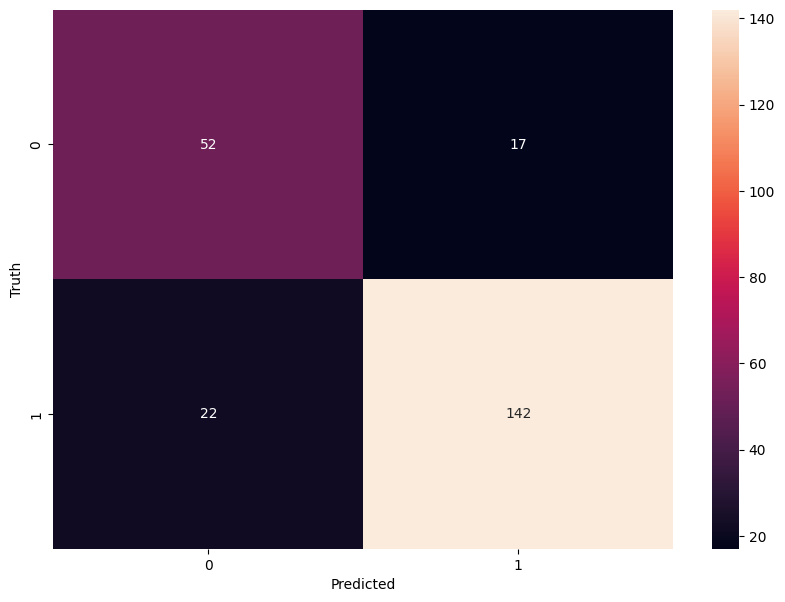

In [10]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

plot_confusion_matrix(test_label, predictions)

In [11]:
print('Bert_model with initial data results:')

# show accuracy
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(test_label, predictions))

# show precision
from sklearn.metrics import precision_score
print("Precision:", precision_score(test_label, predictions))

# show recall
from sklearn.metrics import recall_score
print("Recall:", recall_score(test_label, predictions))

# show f1 score
from sklearn.metrics import f1_score
print("F1 Score:", f1_score(test_label, predictions))

# roc auc score
from sklearn.metrics import roc_auc_score
print("ROC AUC Score:", roc_auc_score(test_label, predictions))


Bert_model with pseudo_labeled_data results:
Accuracy: 0.8326180257510729
Precision: 0.8930817610062893
Recall: 0.8658536585365854
F1 Score: 0.8792569659442725
ROC AUC Score: 0.8097384234711912


In [8]:
model.save('./model', save_format='tf')

INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets


In [7]:
inputs = dict(tokenizer(["This is a factual sentence that can be seen in a good light don't you think so, but it seems like they're all unbiased.","YouTube is making clear there will be no “birtherism” on its platform during this year’s U.S. presidential election – a belated response to a type of conspiracy theory more prevalent in the 2012 race.", "The increasingly bitter dispute between American women’s national soccer team and the U.S. Soccer Federation spilled onto the field Wednesday night when players wore their warm-up jerseys inside outin a protest before their 3-1 victory over Japan.","A professor who teaches climate change classes — a subject some would question as a legitimate area of study — said she has seen students who suffer fear, grief, stress, and anxiety about the future."], padding=True, truncation=True, return_tensors="tf"))

In [14]:
print(inputs)

{'input_ids': <tf.Tensor: shape=(4, 50), dtype=int32, numpy=
array([[  101,  2023,  2003,  1037, 25854,  6251,  2008,  2064,  2022,
         2464,  1999,  1037,  2204,  2422,  2123,  1005,  1056,  2017,
         2228,  2061,  1010,  2021,  2009,  3849,  2066,  2027,  1005,
         2128,  2035,  4895, 11607,  6924,  1012,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0],
       [  101,  7858,  2003,  2437,  3154,  2045,  2097,  2022,  2053,
         1523,  4182, 11124,  6491,  1524,  2006,  2049,  4132,  2076,
         2023,  2095,  1521,  1055,  1057,  1012,  1055,  1012,  4883,
         2602,  1516,  1037, 20252,  3064,  3433,  2000,  1037,  2828,
         1997,  9714,  3399,  2062, 15157,  1999,  1996,  2262,  2679,
         1012,   102,     0,     0,     0],
       [  101,  1996,  6233,  8618,  7593,  2090,  2137,  2308,  1521,
         1055,  2120,  4715,  2136,  1998,  1996,  1057,  1012,  1055,

In [16]:
# Load the model from the local folder for testing purposes
# modelOpen = tf.keras.models.load_model('./model')

import numpy as np
from scipy.special import softmax
#Testing if the loaded model works
newPrediction = modelOpen.predict(inputs)
mutatedToSoftmax = softmax(newPrediction['logits'])
predictionArray = np.argmax(mutatedToSoftmax, axis=1)
print(predictionArray)


1/1 [==============================] - 0s 280ms/step
[1 1 0 0]
